In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from utils import (Expando, _calculate_S_star_BL_G,_calculate_S_star_BL_L, calculate_cvar_left, _left_tail_weighted_sum, _left_tail_mask,compute_cvar_derivative_mixed  )
import gurobipy as gp
from gurobipy import GRB
import copy
%matplotlib inline


In [69]:
# Load Scenario Data
num_scenarios = 500
time_horizon = 20 #  5,10,20
discount_rate_G = 0.00 # %
discount_rate_L = 0.00 # %
alpha = 0.95  # Weighting factor for strike price calculation
contract_type = 'Baseload'  # Baseload ,PAP

#Discount Array 
discount_factors_G = 1 / (1 + discount_rate_G) ** np.arange(time_horizon)
discount_factors_G = discount_factors_G[:, None]

discount_factors_L = 1 / (1 + discount_rate_L) ** np.arange(time_horizon)
discount_factors_L = discount_factors_L[:, None]


scenario_pattern_reduced = f"{{type}}_scenarios_reduced_{time_horizon}y_{num_scenarios}s.csv"

# Load price scenarios
prices_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='price')}", index_col=0) # Mio EUR/GWh
prices_df.index = pd.to_datetime(prices_df.index)   
prices = prices_df.values
prices_mwh = prices_df * 1000  # Convert from EUR/GWh to EUR/MWh

#prices_mwh = prices_mwh + 0.01*prices_mwh.mean().mean()

# Load production scenarios
prod_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='production')}", index_col=0) # GWh
prod_df.index = pd.to_datetime(prod_df.index)
prod = prod_df.values
# Load capture rate scenarios
CR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='capture_rate')}", index_col=0)
CR_df.index = pd.to_datetime(CR_df.index)    # Load load scenarios
CR = CR_df.values
load_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load')}", index_col=0) # GWh
load_df.index = pd.to_datetime(load_df.index)
load = load_df.values

LR_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='load_capture_rate')}", index_col=0) # %
LR_df.index = pd.to_datetime(LR_df.index)
LR = LR_df.values

probability_df = pd.read_csv(f"scenarios/{scenario_pattern_reduced.format(type='probabilities')}", index_col=0) # 
PROB = probability_df.values.flatten()  # Probability array

In [70]:
class NashBargaining:
    def __init__(self, input_data):
        """Initialize contract negotiation model with loaded scenarios.
        
        Args:
            input_data: Input data object containing loaded scenarios and parameters
        """        
        self.data = input_data
        self.results = Expando()
        self.variables = Expando()
        self.constraints = Expando()
        
        self._build_model()

    def _get_S(self, s=None):
        """Helper method to access strike price variable S.
        
        Args:
            s: Scenario index (optional, required if S is scenario-indexed)
            
        Returns:
            Gurobi variable (S[s] if indexed, S if scalar)
        """
        if self.data.Scenarios_S:
            if s is None:
                raise ValueError("Scenario index required when S is scenario-indexed")
            return self.variables.S[s]
        else:
            return self.variables.S

    def _get_M(self, s=None):
        """Helper method to access contract amount variable M.
        
        Args:
            s: Scenario index (optional, required if M is scenario-indexed)
            
        Returns:
            Gurobi variable (M[s] if indexed, M if scalar)
        """
        if self.data.Scenarios_M:
            if s is None:
                raise ValueError("Scenario index required when M is scenario-indexed")
            return self.variables.M[s]
        else:
            return self.variables.M

    def _build_variables(self):
        """Build optimization variables for contract negotiation."""
        EPS = 1e-8  # Small positive number for numerical stability
        
        # Define log-based auxiliary variables
        for name in ['arg_G', 'arg_L', 'log_arg_G', 'log_arg_L']:
              setattr(self.variables, name, self.model.addVar(lb=EPS, name=name))

        # Define core optimization variables (per scenario or scalar)
        if self.data.Scenarios_S:
            setattr(self.variables, 'S', self.model.addVars(self.data.SCENARIOS, lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))
        else: 
            setattr(self.variables, 'S', self.model.addVar(lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))

        if self.data.Scenarios_M:
            setattr(self.variables, 'M', self.model.addVars(self.data.SCENARIOS, lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))
        else:
            setattr(self.variables, 'M', self.model.addVar(lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))

        # Define auxiliary variables for optimization
        for name in ['zeta_G', 'zeta_L']:
            setattr(self.variables, name, self.model.addVar(name=f'Zeta_Auxillary_{name[-1]}', lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY))

        # Define scenario-based eta variables
        for name in ['eta_G', 'eta_L']:
            setattr(self.variables, name, self.model.addVars(self.data.SCENARIOS, name=f'Auxillary_Variable_{name[-1]}', lb=0, ub=gp.GRB.INFINITY))

        self.model.update()

    def _build_constraints(self):
        """Build constraints for contract negotiation."""
        # Strike price constraints (bounds already set in variable creation, but add explicit constraints if needed)
        if self.data.Scenarios_S:
            self.constraints.strike_price_constraint_min = self.model.addConstrs(
                (self._get_S(s) >= self.data.strikeprice_min for s in self.data.SCENARIOS), 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstrs(
                (self._get_S(s) <= self.data.strikeprice_max for s in self.data.SCENARIOS), 
                name='Strike_Price_Max')
        else:
            self.constraints.strike_price_constraint_min = self.model.addConstr(
                self._get_S() >= self.data.strikeprice_min, 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstr(
                self._get_S() <= self.data.strikeprice_max, 
                name='Strike_Price_Max')
        
        # Contract amount constraints
        if self.data.Scenarios_M:
            self.constraints.contract_amount_constraint_min = self.model.addConstrs(
                (self._get_M(s) >= self.data.contract_amount_min for s in self.data.SCENARIOS), 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstrs(
                (self._get_M(s) <= self.data.contract_amount_max for s in self.data.SCENARIOS), 
                name='Contract_Amount_Max')
        else:
            self.constraints.contract_amount_constraint_min = self.model.addConstr(
                self._get_M() >= self.data.contract_amount_min, 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstr(
                self._get_M() <= self.data.contract_amount_max, 
                name='Contract_Amount_Max')

        # Log constraints (on aggregate arguments)
        self.model.addGenConstrLog(self.variables.arg_G, self.variables.log_arg_G, 'log_G')
        self.model.addGenConstrLog(self.variables.arg_L, self.variables.log_arg_L, 'log_L')

        # Convert to numpy arrays for consistent indexing
        capture_rate_array = self.data.capture_rate
        price_G_array = self.data.price_G
        production_G_array = self.data.production_G
        load_scenarios_array = self.data.load_scenarios
        load_CR_array = self.data.load_CR
        price_L_array = self.data.price_L

        # Pre-compute constant terms for each scenario
        generator_const_per_scenario = (
            self.data.discount_factors_G_arr * capture_rate_array * price_G_array * production_G_array
        ).sum(axis=0) - self.data.CAPEX  # Sum over time for each scenario

        load_const_per_scenario = (
            -self.data.discount_factors_L_arr * load_scenarios_array * load_CR_array * price_L_array
        ).sum(axis=0)  # Sum over time for each scenario

        # Generator eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )

        # Load eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )

        self.model.update()

    def _build_objective(self):
        """Build the objective function for contract negotiation."""
        # Pre-extract all data as numpy arrays
        prob_vals = self.data.PROB
        capture_rate_vals = self.data.capture_rate
        price_G_vals = self.data.price_G
        production_G_vals = self.data.production_G
        load_scenarios_vals = self.data.load_scenarios
        load_CR_vals = self.data.load_CR
        price_L_vals = self.data.price_L

        # Calculate expected utilities with contract
        eta_sum_G = gp.quicksum(self.data.PROB[s] * self.variables.eta_G[s] for s in self.data.SCENARIOS)
        eta_sum_L = gp.quicksum(self.data.PROB[s] * self.variables.eta_L[s] for s in self.data.SCENARIOS)

        # Build expected earnings expressions based on indexing configuration
        if not self.data.Scenarios_S and not self.data.Scenarios_M:
            # Both scalar - use original vectorized approach for efficiency
            gen_revenue_const = np.sum(prob_vals * capture_rate_vals * 
                            price_G_vals * production_G_vals * 
                            self.data.discount_factors_G_arr) - self.data.CAPEX
            
            S_coeff_G = np.sum(prob_vals * self.data.discount_factors_G_arr)
            M_coeff_G = -np.sum(prob_vals * price_G_vals * self.data.discount_factors_G_arr)
            
            EuG = (gen_revenue_const + 
                    S_coeff_G * self.variables.S * self.variables.M +
                    M_coeff_G * self.variables.M)
            
            load_revenue_const = np.sum(prob_vals * load_scenarios_vals * 
                                    (- load_CR_vals * price_L_vals) * self.data.discount_factors_L_arr)
            
            S_coeff_L = -np.sum(prob_vals * self.data.discount_factors_L_arr)
            M_coeff_L = np.sum(prob_vals * price_L_vals * self.data.discount_factors_L_arr)
            
            EuL = (load_revenue_const + 
                S_coeff_L * self.variables.S * self.variables.M + 
                M_coeff_L * self.variables.M)

        elif self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr) - self.data.CAPEX        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        elif self.data.Scenarios_S and not self.data.Scenarios_M:
            # Only S is scenario-indexed, M is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        else:  # not self.data.Scenarios_S and self.data.Scenarios_M
            # Only M is scenario-indexed, S is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)
        
        # CVaR terms
        CVaR_G = self.variables.zeta_G - (1/(1-self.data.alpha)) * eta_sum_G
        CVaR_L = self.variables.zeta_L - (1/(1-self.data.alpha)) * eta_sum_L

        # Utilities
        U_G = (1-self.data.A_G) * EuG + self.data.A_G * CVaR_G
        U_L = (1-self.data.A_L) * EuL + self.data.A_L * CVaR_L

        # Set objective based on bargaining power
        if self.data.tau_G == 1:
            self.model.setObjective(U_G - self.data.Zeta_G, GRB.MAXIMIZE)
            self.model.addConstr(U_L - self.data.Zeta_L >= 1e-8, "UL_non_negative")
        elif self.data.tau_L == 1:
            self.model.setObjective(U_L - self.data.Zeta_L, GRB.MAXIMIZE)
            self.model.addConstr(U_G - self.data.Zeta_G >= 1e-8, "UG_non_negative")
        else:
            # Nash bargaining solution
            self.model.addConstr(
                self.variables.arg_G == U_G - self.data.Zeta_G, 
                "arg_G_constr"
            )
            self.model.addConstr(
                self.variables.arg_L == U_L - self.data.Zeta_L,
                "arg_L_constr"
            )
            self.model.setObjective(
                self.data.tau_G * self.variables.log_arg_G + self.data.tau_L * self.variables.log_arg_L, 
                GRB.MAXIMIZE
            )

        self.model.update()

    def _calculate_revenues(self, strike_arr=None, amount_arr=None):
        """Calculate scenario-level revenues.

        Args:
            strike_arr: Array of strike prices (length = num_scenarios)
            amount_arr: Array of contract amounts (length = num_scenarios)

        Returns:
            Tuple of (EuG, SMG, EuL, SML) arrays (each length = num_scenarios)
        """
        num_s = self.data.num_scenarios
        
        # Read decision values if not provided
        if strike_arr is None:
            if self.data.Scenarios_S:
                strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
            else:
                strike_arr = np.full(num_s, self._get_S().x)
        
        if amount_arr is None:
            if self.data.Scenarios_M:
                amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
            else:
                amount_arr = np.full(num_s, self._get_M().x)

        # Flatten discount factors
        disc_G = self.data.discount_factors_G_arr.flatten()
        disc_L = self.data.discount_factors_L_arr.flatten()

        price_G = self.data.price_G  # shape (T, S)
        price_L = self.data.price_L

        EuG = np.array(self.data.net_earnings_no_contract_priceG_G)  # per-scenario base earnings
        EuL = np.array(self.data.net_earnings_no_contract_priceL_L)

        SMG = np.zeros(num_s)
        SML = np.zeros(num_s)

        # Per-scenario loop
        for s in range(num_s):
            # Generator side: sum over time
            SMG[s] = np.sum((strike_arr[s] - price_G[:, s]) * amount_arr[s] * disc_G)
            # Load side
            SML[s] = np.sum((price_L[:, s] - strike_arr[s]) * amount_arr[s] * disc_L)

        return EuG, SMG, EuL, SML

    def _build_model(self):
        """Initialize and build the complete optimization model."""
        self.model = gp.Model(name='Nash Bargaining Model')
        
        # Set model parameters
        params = {
            'NonConvex': 2,
            'FeasibilityTol': 1e-6,
            'OutputFlag': 0,
            'TimeLimit': 100,
            'ObjScale': 1e-6
            }

        for key, value in params.items():
            self.model.setParam(key, value)
        
        # Build model components
        self._build_variables()
        self._build_constraints()
        self._build_objective()

    def _save_results(self):
        """Save optimization results, including per-scenario revenues and probability-weighted averages."""
        # Save objective
        self.results.objective_value = self.model.ObjVal

        # Extract per-scenario decision values
        num_s = self.data.num_scenarios
        
        if self.data.Scenarios_S:
            strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
        else:
            strike_arr = np.full(num_s, self._get_S().x)
            
        if self.data.Scenarios_M:
            amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
        else:
            amount_arr = np.full(num_s, self._get_M().x)

        # Save per-scenario values (convert strike to €/MWh)
        self.results.strike_price_per_scenario = strike_arr * 1e3
        self.results.contract_amount_per_scenario = amount_arr
        self.results.contract_amount_hour_per_scenario = (amount_arr / 8760.0) * 1e3

        # Calculate revenues per scenario
        EuG, SMG, EuL, SML = self._calculate_revenues(strike_arr=strike_arr, amount_arr=amount_arr)

        total_earnings_G = EuG + SMG
        total_earnings_L = EuL + SML

        # Save per-scenario revenues
        self.results.earnings_G_per_scenario = total_earnings_G
        self.results.earnings_L_per_scenario = total_earnings_L

        # Probability-weighted averages
        probs = np.array(self.data.PROB)
        self.results.avg_strike_price = (probs * strike_arr).sum() * 1e3
        self.results.avg_contract_amount = (probs * amount_arr).sum()
        self.results.avg_contract_amount_hour = (self.results.avg_contract_amount / 8760.0) * 1e3

        self.results.avg_earnings_G = (probs * total_earnings_G).sum()
        self.results.avg_earnings_L = (probs * total_earnings_L).sum()

        # CVaR on resulting distributions (ex-post / recomputed)
        self.results.CVaRG_expost = calculate_cvar_left(total_earnings_G, probs, self.data.alpha)
        self.results.CVaRL_expost = calculate_cvar_left(total_earnings_L, probs, self.data.alpha)

        # Utilities using ex-post CVaR
        utility_G_expost = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * self.results.CVaRG_expost
        utility_L_expost = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * self.results.CVaRL_expost

        self.results.utility_G_expost = utility_G_expost
        self.results.utility_L_expost = utility_L_expost

        # ---- Model-consistent CVaR and utility (use zeta and eta variable values) ----
        # Compute CVaR from model variables: zeta - (1/(1-alpha)) * sum(p_s * eta_s)
        eta_G_sum_model = sum(self.data.PROB[s] * self.variables.eta_G[s].x for s in self.data.SCENARIOS)
        eta_L_sum_model = sum(self.data.PROB[s] * self.variables.eta_L[s].x for s in self.data.SCENARIOS)

        CVaR_G_model = self.variables.zeta_G.x - (1.0 / (1.0 - self.data.alpha)) * eta_G_sum_model
        CVaR_L_model = self.variables.zeta_L.x - (1.0 / (1.0 - self.data.alpha)) * eta_L_sum_model

        self.results.CVaRG_model = CVaR_G_model
        self.results.CVaRL_model = CVaR_L_model

        # Model-consistent utilities: expected earnings is the same avg_earnings computed above
        utility_G_model = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * CVaR_G_model
        utility_L_model = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * CVaR_L_model

        self.results.utility_G_model = utility_G_model
        self.results.utility_L_model = utility_L_model

        # Threat points (from data)
        self.results.Zeta_G = self.data.Zeta_G
        self.results.Zeta_L = self.data.Zeta_L

        # Nash product (use model-consistent utilities for correctness)
        self.results.Nash_Product_model = (utility_G_model - self.results.Zeta_G) * (utility_L_model - self.results.Zeta_L)
        self.results.Nash_Product_expost = (utility_G_expost - self.results.Zeta_G) * (utility_L_expost - self.results.Zeta_L)

        # Sanity checks / warnings
        tol = 1e-6
        if utility_G_model + tol < self.results.Zeta_G:
            print("WARNING: model-consistent utility_G is below threat point (Zeta_G).")
        if utility_L_model + tol < self.results.Zeta_L:
            print("WARNING: model-consistent utility_L is below threat point (Zeta_L).")

        # If ex-post utility is below threat point, warn and show both values for debugging
        if utility_G_expost + tol < self.results.Zeta_G or utility_L_expost + tol < self.results.Zeta_L:
            print("WARNING: ex-post recomputed utility is below threat point. This indicates a mismatch between the model CVaR representation and the ex-post CVaR computation.")
            print(f"Utility_G_model={utility_G_model:.6f}, Utility_G_expost={utility_G_expost:.6f}, Zeta_G={self.results.Zeta_G:.6f}")
            print(f"Utility_L_model={utility_L_model:.6f}, Utility_L_expost={utility_L_expost:.6f}, Zeta_L={self.results.Zeta_L:.6f}")

        # Save final reported utilities (use model-consistent by default)
        self.results.utility_G = utility_G_model
        self.results.utility_L = utility_L_model
        self.results.CVaRG = CVaR_G_model
        self.results.CVaRL = CVaR_L_model
    
    def run(self):
        """Run the optimization model."""
        self.model.optimize()

        if self.model.status == GRB.OPTIMAL:
            self._save_results()
            self.display_results()
            self.results.optimal = True
        else:
            self.results.optimal = False
            raise RuntimeError(f"Optimization of {self.model.ModelName} was not successful")

    def display_results(self):
        """Display optimization results."""
        print("\n-------------------   RESULTS GUROBI  -------------------")
        results = {
            "Optimal Objective Value (Log)": self.results.objective_value,
            "Avg Strike Price (EUR/MWh)": self.results.avg_strike_price,
            "Lower Strike Price SR* (EUR/MWh)": self.data.SR_star_new,
            "Upper Strike Price SU* (EUR/MWh)": self.data.SU_star_new,
            "Avg Contract Amount (GWh/year)": self.results.avg_contract_amount,
            "Avg Contract Amount (MWh)": self.results.avg_contract_amount_hour,
            "Avg Earnings G": self.results.avg_earnings_G,
            "Avg Earnings L": self.results.avg_earnings_L,
            "CVaR G": self.results.CVaRG,
            "CVaR L": self.results.CVaRL,
            "Utility G": self.results.utility_G,
            "Utility L": self.results.utility_L,
            "Threat Point G": self.results.Zeta_G,
            "Threat Point L": self.results.Zeta_L,
            "Nash Product": self.results.Nash_Product_model
        }
        for key, value in results.items():
            try:
                print(f"{key}: {value:.5f}")
            except Exception:
                print(f"{key}: {value}")

In [71]:
class ContractData:
    def __init__(self, scenario_path, time_horizon, num_scenarios, discount_rate_G=0.02, discount_rate_L=0.05, alpha=0.95,
                 strikeprice_min=0, strikeprice_max=1000, contract_amount_min=0, contract_amount_max=1000,
                 A_G=0.5, A_L=0.5, tau_G=0.5, tau_L=0.5, Scenarios_S=False, Scenarios_M=False,
                 Discount=True, K_G_lambda_Sigma=0, K_L_lambda_Sigma=0):
        """Initialize data for contract negotiation.

        Args:
            scenario_path (str): Path to scenario data files
            time_horizon (int): Time horizon in years
            num_scenarios (int): Number of scenarios
            discount_rate_G (float): Generator's discount rate (default: 0.02)
            discount_rate_L (float): Load's discount rate (default: 0.05)
            alpha (float): CVaR confidence level (default: 0.95)
            strikeprice_min (float): Minimum strike price (default: 0)
            strikeprice_max (float): Maximum strike price (default: 1000)
            contract_amount_min (float): Minimum contract amount (default: 0)
            contract_amount_max (float): Maximum contract amount (default: Capacity * 8760 / 1000)
            A_G (float): Generator's risk aversion parameter (default: 0.5)
            A_L (float): Load's risk aversion parameter (default: 0.5)
            tau_G (float): Generator's bargaining power (default: 0.5)
            tau_L (float): Load's bargaining power (default: 0.5)
            Scenarios_S (bool): Strike Price indexed by scenarios (default: False)
            Scenarios_M (bool): Contract Amount M indexed by scenarios (default: False)
            Discount (bool): Use discounting for strike price borders (default: True)
            K_G_lambda_Sigma (float): Generator's lambda adjustment constant (default: 0)
            K_L_lambda_Sigma (float): Load's lambda adjustment constant (default: 0)
        """
        # Store parameters
        self.time_horizon = time_horizon
        self.num_scenarios = num_scenarios
        self.alpha = alpha
        self.A_G = A_G
        self.A_L = A_L
        self.tau_G = tau_G
        self.tau_L = tau_L
        self.Scenarios_S = Scenarios_S
        self.Scenarios_M = Scenarios_M
        self.Discount = Discount
        self.K_G_lambda_Sigma = K_G_lambda_Sigma
        self.K_L_lambda_Sigma = K_L_lambda_Sigma
        self.CAPEX_MW  = 1.18  # mio Eur/MW

        # Contract limits
        self.strikeprice_min = strikeprice_min
        self.strikeprice_max = strikeprice_max
        self.contract_amount_min = contract_amount_min
        self.contract_amount_max = contract_amount_max
        self.capacity_MW = self.contract_amount_max * 1000 / 8760  # MW
        self.CAPEX   = self.CAPEX_MW * self.capacity_MW  # Mio EUR


        # Calculate discount factors
        self.discount_factors_G_arr = (1 / (1 + discount_rate_G) ** np.arange(time_horizon))[:, None]
        self.discount_factors_L_arr = (1 / (1 + discount_rate_L) ** np.arange(time_horizon))[:, None]

        # Load scenario data
        self._load_scenarios(scenario_path)

        # Calculate derived values
        self._calculate_derived_values()

        # Calculate strike price borders
        self._calculate_strike_price_borders()
        
    def _load_scenarios(self, scenario_path):
        """Load all scenario data from files."""
        scenario_pattern = f"{{type}}_scenarios_reduced_{20}y_{self.num_scenarios}s.csv"
        
        # Load price scenarios
        self.price_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='price')}", index_col=0).values[:self.time_horizon, :]
        self.price_L = self.price_G.copy()  # Assuming same prices for both parties
        
        # Load production scenarios
        self.production_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='production')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load capture rate scenarios
        self.capture_rate = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='capture_rate')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load load scenarios
        self.load_scenarios = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load')}", 
                                        index_col=0).values[:self.time_horizon, :]
        
        # Load load capture rate scenarios
        self.load_CR = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load_capture_rate')}", 
                                 index_col=0).values[:self.time_horizon, :]
        
        # Load probabilities
        self.PROB = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='probabilities')}", 
                              index_col=0).values.flatten()
        
    def _calculate_derived_values(self):
        """Calculate derived values needed for optimization."""
        # Time indices
        self.TIME = range(self.time_horizon)
        self.SCENARIOS = range(self.num_scenarios)
        
        # Calculate no-contract earnings
        self.net_earnings_no_contract_priceG_G = (self.discount_factors_G_arr * self.capture_rate * self.price_G * self.production_G).sum(axis=0) - self.CAPEX
        self.net_earnings_no_contract_priceL_L = (-self.discount_factors_L_arr * self.load_scenarios * self.load_CR * self.price_L).sum(axis=0)
        
        # Calculate CVaR for no-contract case
        self.CVaR_no_contract_G = calculate_cvar_left(self.net_earnings_no_contract_priceG_G, self.PROB, self.alpha)
        self.CVaR_no_contract_L = calculate_cvar_left(self.net_earnings_no_contract_priceL_L, self.PROB, self.alpha)
        
        # Calculate threat points (Zeta values)
        self.Zeta_G = ((1 - self.A_G) * (self.PROB * self.net_earnings_no_contract_priceG_G).sum() + self.A_G * self.CVaR_no_contract_G)
        self.Zeta_L = ((1 - self.A_L) * (self.PROB * self.net_earnings_no_contract_priceL_L).sum() + self.A_L * self.CVaR_no_contract_L)
        
        # Calculate expected price
        self.expected_price = (self.PROB * self.price_G.mean(axis=0)).sum()
        
        # Calculate capture price for generator
        self.Capture_price_G_avg = ((self.capture_rate * self.price_G).sum(axis=0) / self.capture_rate.sum(axis=0))

        # Calculate expected lambda sum (needed for strike price borders)
        self.expected_lambda_sum_true = self.price_G.sum(axis=0)  # Sum over time for each scenario

    def _calculate_strike_price_borders(self):
        """Calculate strike price borders (SR* and SU*) based on CVaR calculations."""
        time_periods = self.price_G.shape[0]

        if self.Discount:
            # Use discounted prices
            discounted_prices_G = (self.price_G * self.discount_factors_G_arr)
            discounted_prices_L = (self.price_L * self.discount_factors_L_arr)
            
            # Sum over time for each scenario
            lambda_sum_G_discounted = discounted_prices_G.sum(axis=0)
            lambda_sum_L_discounted = discounted_prices_L.sum(axis=0)
            
            # Expected values with discounting
            expected_lambda_sum_discounted_G = (self.PROB * lambda_sum_G_discounted).sum()
            expected_lambda_sum_discounted_L = (self.PROB * lambda_sum_L_discounted).sum()

            # Get masks using discounted earnings
            ord_G, bidx_G = _left_tail_mask(
                self.net_earnings_no_contract_priceG_G,
                self.PROB, 
                self.alpha
            )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_G_discounted,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )

            tail_L = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_L_discounted,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )

            self.term2_G_new =  (
                ((1-self.A_G) * expected_lambda_sum_discounted_G + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / ( self.discount_factors_G_arr.sum())

            # Calculate terms with discounted values
            self.term3_L_new = (
                ((1-self.A_L) * expected_lambda_sum_discounted_L + 
                self.K_L_lambda_Sigma) + 
                self.A_L * tail_L
            ) / ( self.discount_factors_L_arr.sum())
        else:
           

            ord_G, bidx_G = _left_tail_mask(
                    self.net_earnings_no_contract_priceG_G,
                    self.PROB, 
                    self.alpha
                )

                # Get masks using discounted earnings
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB, 
                self.alpha
            )

            # Calculate CVaR terms with discounted values
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_G, bidx_G, 
                self.alpha
            )
            
            tail_L = _left_tail_weighted_sum(
                self.PROB,
                self.expected_lambda_sum_true,  # Use discounted sum
                ord_L, bidx_L, 
                self.alpha
            )
            
            self.term2_G_new = (
                ((1-self.A_G) * self.expected_lambda_sum_true + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / time_periods
            self.term3_L_new = (self.expected_lambda_sum_true
                                + self.A_L * tail_L
                            + self.K_L_lambda_Sigma  - self.A_L * self.expected_lambda_sum_true )  / time_periods   # SR* numerator for LSE
            
        
        # Calculate SR* using Equation (27) - Minimum of the relevant terms
        self.SR_star_new = np.min([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh
        # Calculate SU* using Equation (28) - Maximum of the relevant terms
        self.SU_star_new = np.max([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh


        # Calculate CVaR derivative
        M = 2
        S = 25
        alpha = 0.95

        dcvar_dM = compute_cvar_derivative_mixed(
            M*8760*1e-3, S*1e-3, self.production_G, self.capture_rate,
            self.price_G, self.discount_factors_L_arr, self.PROB, self.alpha,
        )

        print(f"dCVaR/dM = {dcvar_dM:.4f}")
        self.SR_star_new = np.min([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh
        # Calculate SU* using Equation (28) - Maximum of the relevant terms
        self.SU_star_new = np.max([self.term2_G_new, self.term3_L_new])  # Convert from $/GWh to $/MWh

        print(f"Initial Threshold at M=0 SR* [EUR/MWh]: {self.SR_star_new*1e3:.3f}")
        print(f"Initial Threshold at M=0 SU* [EUR/MWh]: {self.SU_star_new*1e3:.3f}")

In [217]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.0
discount_rate_L = 0.0
A_G = 0.5
A_L = 0.5
tau_G = 0.5
tau_L = 1-tau_G


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
model = NashBargaining(contract_data)
model.run()

dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 76.046
Initial Threshold at M=0 SU* [EUR/MWh]: 94.016
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 2.28832
Avg Strike Price (EUR/MWh): 89.11819
Lower Strike Price SR* (EUR/MWh): 0.07605
Upper Strike Price SU* (EUR/MWh): 0.09402
Avg Contract Amount (GWh/year): 104.42837
Avg Contract Amount (MWh): 11.92105
Avg Earnings G: 69.46657
Avg Earnings L: -263.45530
CVaR G: 48.91816
CVaR L: -282.35029
Utility G: 59.19237
Utility L: -272.90279
Threat Point G: 49.33399
Threat Point L: -282.76117
Nash Product: 97.18762



PART 1: INITIAL THRESHOLDS AT M=0

Computing initial thresholds for different risk aversion combinations...
Generator risk aversions: [0.1, 0.5, 0.9]
Load risk aversions: 100 values from 0.0 to 1.0
Data shape: prod=(20, 500), prices=(20, 500), CR=(20, 500)

  A_G = 0.5... ✓ Complete
  A_G = 0.5... ✓ Complete
  A_G = 0.5... ✓ Complete

✓ Initial threshold calculations complete!

PART 2: DYNAMIC THRESHOLDS PER M

Computing thresholds for A_G=0.5, A_L varied...
  Initial SR* (low):  0.04 EUR/MWh
  Initial SU* (high): 0.12 EUR/MWh
  Initial S_G*:       76.05 EUR/MWh
  Initial S_L*:       94.02 EUR/MWh

Annual production range: [3.32, 11.75] MWh/year
Annual consumption range: [14.18, 20.61] MWh/year
Contract amount range: [0, 262.80] MWh/year

Computing thresholds for each M value and A_L combination...
  A_L = 0.5... ✓ Complete
  A_L = 0.5... ✓ Complete
  A_L = 0.5... ✓ Complete

✓ Dynamic threshold calculations complete!

GENERATING PLOTS



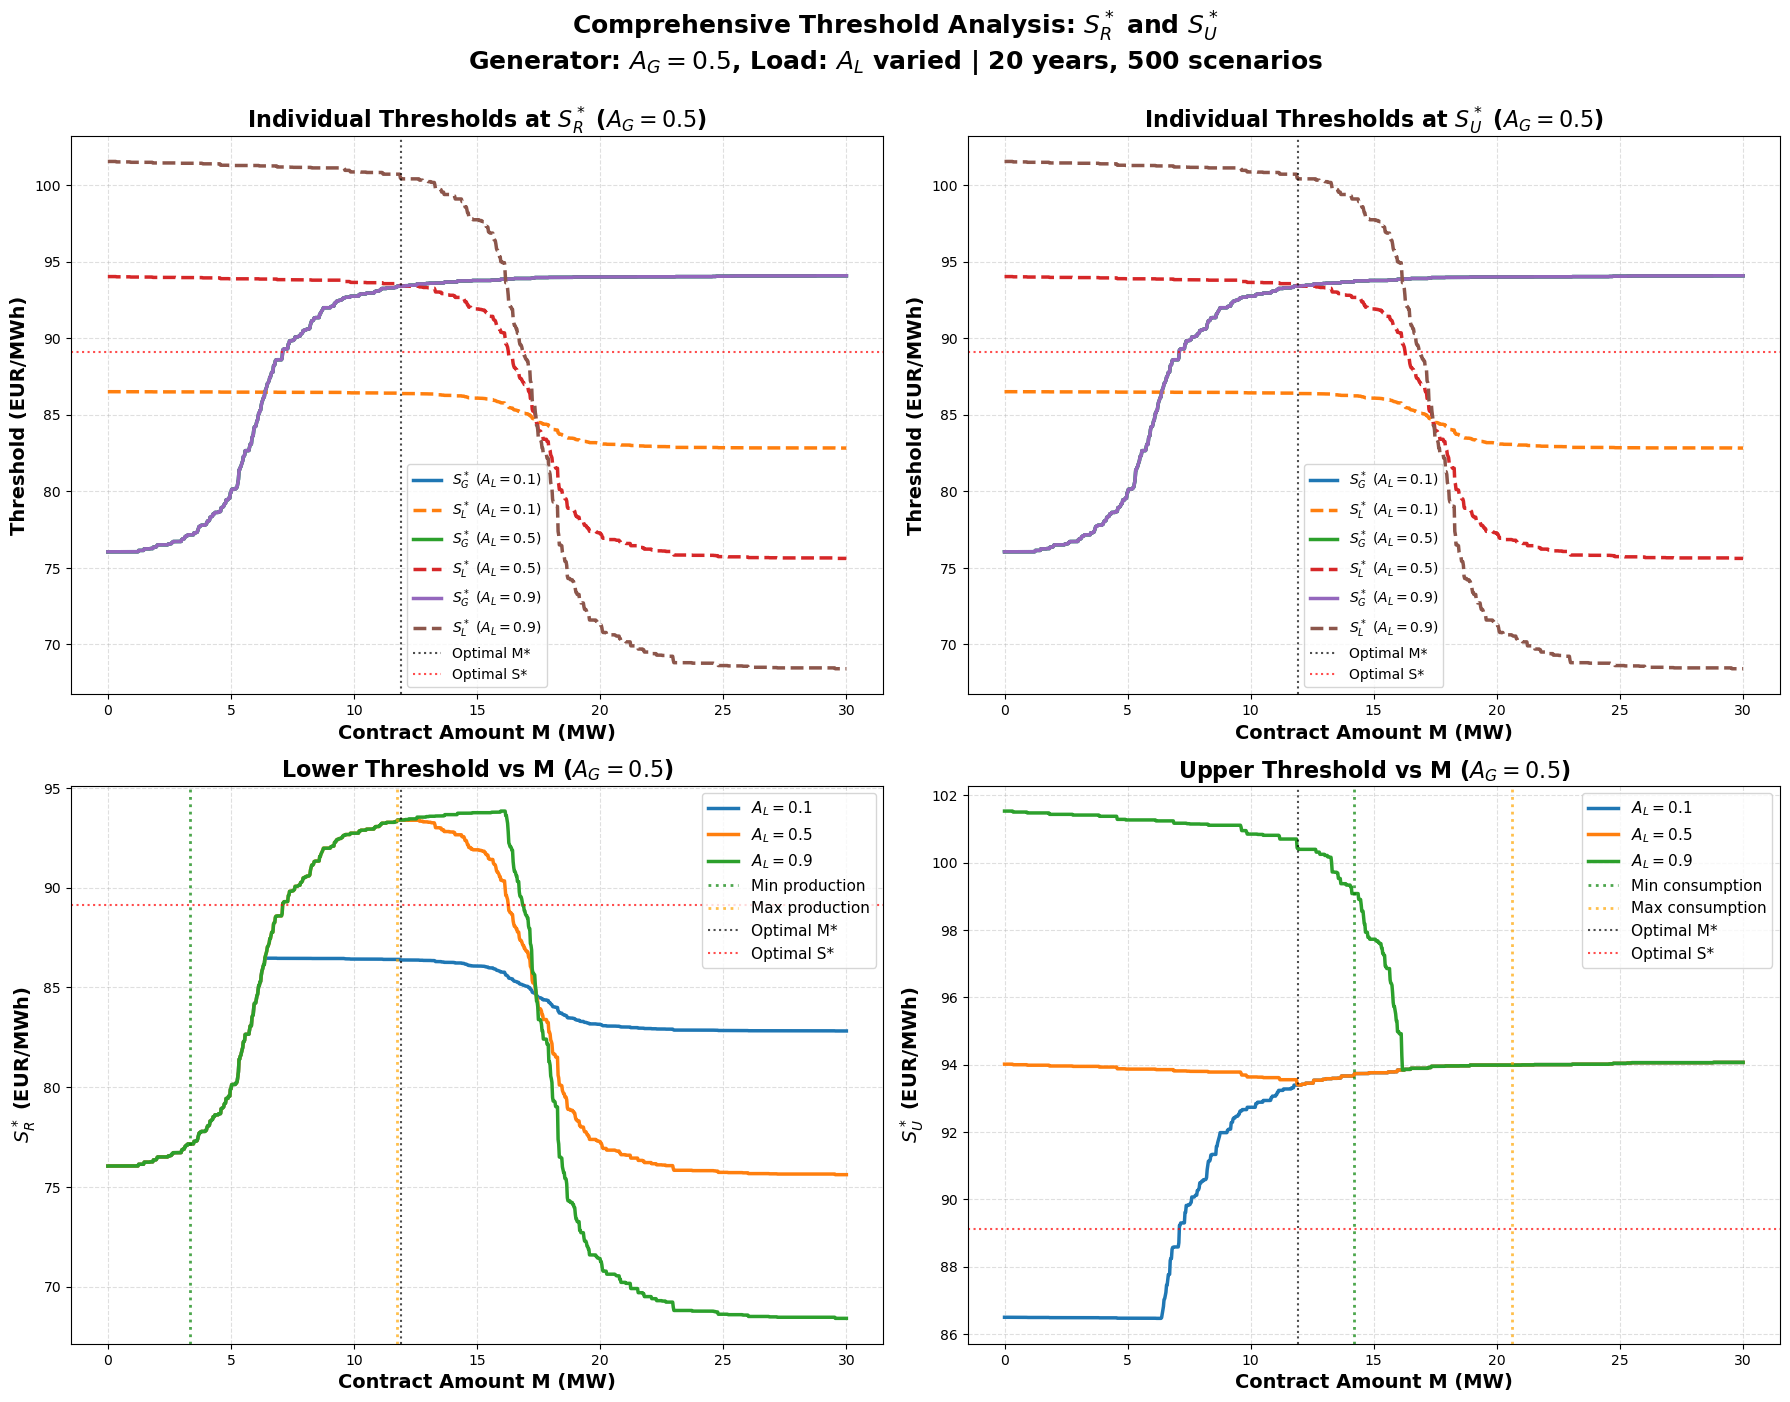

✓ Plots generated and saved



In [229]:

def calculate_initial_thresholds(
    production: np.ndarray,      # Shape (n_years, n_scenarios) - MWh per year
    capture_rate: np.ndarray,    # Shape (n_years, n_scenarios)
    prices: np.ndarray,          # Shape (n_years, n_scenarios) - EUR/MWh
    consumption: np.ndarray,    # Shape (n_years, n_scenarios) - MWh per year
    load_CR: np.ndarray,       # Shape (n_years, n_scenarios)
    probabilities: np.ndarray,   # Shape (n_scenarios,)
    A_G: float,
    A_L: float,
    alpha: float = 0.95,
    discount_factors_G: np.ndarray = None,  # Shape (n_years, 1)
    discount_factors_L: np.ndarray = None   # Shape (n_years, 1)
) -> dict:
    """
    Calculate S_R^* and S_U^* at M=0 (initial thresholds).
    
    These represent the feasible strike price range at the no-contract baseline.
    
    DATA STRUCTURE: (years, scenarios)
    - Each row = one year
    - Each column = one scenario
    
    Parameters:
    -----------
    production : np.ndarray
        Shape (n_years, n_scenarios) - production levels (MWh per year)
    capture_rate : np.ndarray
        Shape (n_years, n_scenarios) - capture rates
    prices : np.ndarray
        Shape (n_years, n_scenarios) - spot prices (EUR/MWh)
    probabilities : np.ndarray
        Shape (n_scenarios,) - scenario probabilities
    A_G : float
        Generator's risk aversion [0, 1]
    A_L : float
        Load's risk aversion [0, 1]
    alpha : float
        CVaR confidence level (default 0.95)
    discount_factors : np.ndarray, optional
        Shape (n_years, 1) - discount factors
    
    Returns:
    --------
    dict with keys:
        'S_G_star': Generator's threshold (EUR/MWh per year)
        'S_L_star': Load's threshold
        'SR_star': min(S_G_star, S_L_star)
        'SU_star': max(S_G_star, S_L_star)
        'mean_price': Mean spot price
        'tail_price_G': Average price in generator's tail
        'tail_price_L': Average price in load's tail
        'feasible': Boolean - whether bargaining range exists
    """
    
    n_years, n_scenarios = production.shape
    
    # Normalize probabilities
    probabilities = probabilities / probabilities.sum()
    
    # ========================================
    # GENERATOR CALCULATIONS
    # ========================================
    

    # Apply discounting if provided
    if discount_factors_G is not None:
        discounted_prices_G = prices * discount_factors_G
        lambda_sum_G = discounted_prices_G.sum(axis=0)
        T_effective_G = discount_factors_G.sum()
    else:
        lambda_sum_G = prices.sum(axis=0)
        T_effective_G = n_years

    if discount_factors_L is not None:
        discounted_prices_L = prices * discount_factors_L
        lambda_sum_L = discounted_prices_L.sum(axis=0)
        T_effective_L = discount_factors_L.sum()
    else:
        lambda_sum_L = prices.sum(axis=0)
        T_effective_L = n_years
        # At M=0, earnings are just spot revenue (no contract)
    
    
    total_production_CR = production * capture_rate  # (n_years, n_scenarios)
    spot_revenue_G = (total_production_CR * prices * discount_factors_G).sum(axis=0)  # Sum over years → (n_scenarios,)
    
    # Expected value
    expected_lambda_G = (probabilities * lambda_sum_G).sum()
    expected_lambda_L = (probabilities * lambda_sum_L).sum()



    
    # LEFT TAIL: worst earnings for generator
    ord_G, bidx_G = _left_tail_mask(spot_revenue_G, probabilities, alpha)
    
    # Conditional expectation in tail
    tail_lambda_G = _left_tail_weighted_sum(
        probabilities, lambda_sum_G, ord_G, bidx_G, alpha
    )
    
    # Calculate S^* for generator (per year)
    S_G_star = ((1 - A_G) * expected_lambda_G + A_G * tail_lambda_G) / T_effective_G
    
    # ========================================
    # LOAD CALCULATIONS
    # ========================================
    total_consumption_LR = consumption * load_CR  # (n_years, n_scenarios)
    spot_revenue_L = -(total_consumption_LR * prices * discount_factors_L).sum(axis=0)  # Sum over years → (n_scenarios,)
    
    # Load's LEFT TAIL: high price scenarios
    ord_L, bidx_L = _left_tail_mask(spot_revenue_L, probabilities, alpha)
    
    # Conditional expectation in high-price tail
    tail_lambda_L = _left_tail_weighted_sum(
        probabilities, lambda_sum_L, ord_L, bidx_L, alpha
    )
    
    # Calculate S^* for load (per year)
    S_L_star = ((1 - A_L) * expected_lambda_L + A_L * tail_lambda_L) / T_effective_L
    
    # ========================================
    # FINAL THRESHOLDS
    # ========================================
    
    SR_star = min(S_G_star, S_L_star)
    SU_star = max(S_G_star, S_L_star)
    
    return {
        'S_G_star': S_G_star*1e3,
        'S_L_star': S_L_star*1e3,
        'SR_star': SR_star*1e3,
        'SU_star': SU_star*1e3,
        'tail_price_G': tail_lambda_G / T_effective_G*1e3,
        'tail_price_L': tail_lambda_L / T_effective_L*1e3,
        'feasible': SR_star < SU_star
    }


def calculate_thresholds_at_M(
    M: float,                    # Annual contract amount (MWh/year)
    S_fixed: float,              # Strike price (EUR/MWh)
    production: np.ndarray,      # Shape (n_years, n_scenarios) - MWh per year
    capture_rate: np.ndarray,    # Shape (n_years, n_scenarios)
    prices: np.ndarray,          # Shape (n_years, n_scenarios) - EUR/MWh
    consumption: np.ndarray,    # Shape (n_years, n_scenarios) - MWh per year
    load_CR: np.ndarray,    # Shape (n_years, n_scenarios)
    probabilities: np.ndarray,   # Shape (n_scenarios,)
    A_G: float,
    A_L: float,
    alpha: float = 0.95,
    discount_factors_G: np.ndarray = None,  # Shape (n_years, 1)
    discount_factors_L: np.ndarray = None  # Shape (n_years, 1)
) -> dict:
    """
    Calculate S^* thresholds at a specific annual contract amount M.
    
    M represents MWh/year commitment (annual contract).
    
    Parameters:
    -----------
    M : float
        Annual contract amount (MWh/year)
    S_fixed : float
        Strike price (EUR/MWh)
    production : np.ndarray
        Shape (n_years, n_scenarios) - production levels (MWh per year)
    
    Returns:
    --------
    dict with keys:
        'S_G_star': Generator's threshold (EUR/MWh)
        'S_L_star': Load's threshold (EUR/MWh)
        'regime': str - 'uniformly_long', 'mixed', or 'uniformly_short'
        'min_production': Minimum annual production (MWh/year)
        'max_production': Maximum annual production (MWh/year)
    """
    
    n_years, n_scenarios = production.shape
    
    # Normalize probabilities
    probabilities = probabilities / probabilities.sum()
    
    # ========================================
    # DETERMINE GENERATOR REGIME
    # ========================================
    
    total_production_CR = production * capture_rate  # (n_years, n_scenarios)
    
    # Min/max annual production across ALL scenario-years
    min_production = total_production_CR.min()  # MWh/year
    max_production = total_production_CR.max()  # MWh/year
    
    if M > max_production:
        regime = 'uniformly_short'
    elif M <= min_production:
        regime = 'uniformly_long'
    else:
        regime = 'mixed'
    
    # ========================================
    # GENERATOR CALCULATIONS AT (M, S_fixed)
    # ========================================
    
    # Calculate earnings at this (M, S_fixed)

    # Apply discounting if provided
    if discount_factors_G is not None:
        discounted_prices_G = prices * discount_factors_G
        lambda_sum_G = discounted_prices_G.sum(axis=0)
        T_effective_G = discount_factors_G.sum()
    else:
        lambda_sum_G = prices.sum(axis=0)
        T_effective_G = n_years

    if discount_factors_L is not None:
        discounted_prices_L = prices * discount_factors_L
        lambda_sum_L = discounted_prices_L.sum(axis=0)
        T_effective_L = discount_factors_L.sum()
    else:
        lambda_sum_L = prices.sum(axis=0)
        T_effective_L = n_years
    
    # Expected value
    expected_lambda_G = (probabilities * lambda_sum_G).sum()
    expected_lambda_L = (probabilities * lambda_sum_L).sum()
    

    spot_revenue_G = (total_production_CR * prices * discount_factors_G).sum(axis=0)  # Sum over years → (n_scenarios,)
    contract_payoff_G = ((S_fixed - prices) * M * discount_factors_G).sum(axis=0)    # Sum over years → (n_scenarios,)
    earnings_G = spot_revenue_G + contract_payoff_G
    

    # LEFT TAIL: worst earnings at this (M, S)
    ord_G, bidx_G = _left_tail_mask(earnings_G, probabilities, alpha)
    
    # Conditional expectation in tail
    tail_lambda_G = _left_tail_weighted_sum(
        probabilities, lambda_sum_G, ord_G, bidx_G, alpha
    )
    
    # Calculate S^* for generator at this M
    S_G_star = ((1 - A_G) * expected_lambda_G + A_G * tail_lambda_G) / T_effective_G
    
    # ========================================
    # LOAD CALCULATIONS AT (M, S_fixed)
    # ========================================
    
    # Load earnings at (M, S_fixed)
    total_consumption_CR = consumption * load_CR  # (n_years, n_scenarios)
    spot_revenue_L = -(total_consumption_CR * prices * discount_factors_L).sum(axis=0)  # Sum over years → (n_scenarios,)
    contract_payoff_L = ((prices - S_fixed) * M * discount_factors_L).sum(axis=0)    # Sum over years → (n_scenarios,)
    earnings_L = spot_revenue_L + contract_payoff_L
    
    
    # LEFT TAIL for load
    ord_L, bidx_L = _left_tail_mask(earnings_L, probabilities, alpha)
    
    # Conditional expectation in tail
    tail_lambda_L = _left_tail_weighted_sum(
        probabilities, lambda_sum_L, ord_L, bidx_L, alpha
    )
    
    # Calculate S^* for load at this M
    S_L_star = ((1 - A_L) * expected_lambda_L + A_L * tail_lambda_L) / T_effective_L
    

    SR_star = min(S_G_star, S_L_star)
    SU_star = max(S_G_star, S_L_star)

    return {
        'S_G_star': S_G_star*1e3,
        'S_L_star': S_L_star*1e3,
        'SR_star': SR_star*1e3,
        'SU_star': SU_star*1e3,
        'regime': regime,
        'tail_price_G': tail_lambda_G / T_effective_G*1e3,
        'tail_price_L': tail_lambda_L / T_effective_L*1e3,
        'feasible': SR_star < SU_star

    }
# ============================================================================
# PART 1: INITIAL THRESHOLDS AT M=0
# ============================================================================

print("\n" + "="*80)
print("PART 1: INITIAL THRESHOLDS AT M=0")
print("="*80 + "\n")

# Define risk aversion ranges
risk_aversion_G = [0.1, 0.5, 0.9]
risk_aversion_L = np.linspace(0.0, 1.0, 100)

# Initialize arrays to store results
n_test = len(risk_aversion_L)
SR_array = np.empty((len(risk_aversion_G), n_test))
SU_array = np.empty((len(risk_aversion_G), n_test))
S_G_array = np.empty((len(risk_aversion_G), n_test))
S_L_array = np.empty((len(risk_aversion_G), n_test))
feasible_array = np.empty((len(risk_aversion_G), n_test), dtype=bool)

print("Computing initial thresholds for different risk aversion combinations...")
print(f"Generator risk aversions: {risk_aversion_G}")
print(f"Load risk aversions: {len(risk_aversion_L)} values from 0.0 to 1.0")
print(f"Data shape: prod={prod.shape}, prices={prices.shape}, CR={CR.shape}\n")

for i, A_G_loop in enumerate(risk_aversion_G):
    print(f"  A_G = {A_G:.1f}...", end=" ")
    for j, A_L_loop in enumerate(risk_aversion_L):
        
        # Calculate initial thresholds
        thresholds = calculate_initial_thresholds(
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G_loop,
            A_L=A_L_loop,
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        # Store results (data already in EUR/MWh)
        SR_array[i, j] = thresholds['SR_star']
        SU_array[i, j] = thresholds['SU_star']
        S_G_array[i, j] = thresholds['S_G_star']
        S_L_array[i, j] = thresholds['S_L_star']
        feasible_array[i, j] = thresholds['feasible']
    
    print(f"✓ Complete")

print(f"\n✓ Initial threshold calculations complete!")

# ============================================================================
# PART 2: DYNAMIC THRESHOLDS AS FUNCTION OF M
# ============================================================================

print("\n" + "="*80)
print("PART 2: DYNAMIC THRESHOLDS PER M")
print("="*80 + "\n")

# Choose specific risk aversion values for M-sweep
A_G_fixed = A_G
# Test multiple A_L values
A_L_values = [0.1, 0.5, 0.9]  # Three different load risk aversions

print(f"Computing thresholds for A_G={A_G_fixed}, A_L varied...")

# Get initial thresholds for the fixed A_G and middle A_L
initial = calculate_initial_thresholds(
    production=prod,
    capture_rate=CR,
    prices=prices,
    consumption=load,
    load_CR=LR,
    probabilities=PROB,
    A_G=A_G_fixed,
    A_L=0.5,  # Use middle value for initial threshold
    alpha=alpha,
    discount_factors_G=discount_factors_G,
    discount_factors_L=discount_factors_L
)

S_fixed_low = 40*1e-3  # EUR/MWh
S_fixed_high = 120*1e-3  # EUR/MWh

print(f"  Initial SR* (low):  {S_fixed_low:.2f} EUR/MWh")
print(f"  Initial SU* (high): {S_fixed_high:.2f} EUR/MWh")
print(f"  Initial S_G*:       {initial['S_G_star']:.2f} EUR/MWh")
print(f"  Initial S_L*:       {initial['S_L_star']:.2f} EUR/MWh\n")

# Define M range based on annual production
total_production_CR = (prod / 8760 * 1e3) * CR  # (n_years, n_scenarios)
min_avg_annual_prod = total_production_CR.min()
max_avg_annual_prod = total_production_CR.max()

total_consumption_LR = (load / 8760 * 1e3) * LR
min_avg_annual_cons = total_consumption_LR.min()
max_avg_annual_cons = total_consumption_LR.max()

M_arr = np.linspace(0, 30 * 8760 * 1e-3, 1200)  # MWh/year

print(f"Annual production range: [{min_avg_annual_prod:.2f}, {max_avg_annual_prod:.2f}] MWh/year")
print(f"Annual consumption range: [{min_avg_annual_cons:.2f}, {max_avg_annual_cons:.2f}] MWh/year")
print(f"Contract amount range: [0, {M_arr.max():.2f}] MWh/year\n")

# Arrays to store results - now indexed by A_L variation
SR_vs_M = np.empty((len(A_L_values), len(M_arr)))
SU_vs_M = np.empty((len(A_L_values), len(M_arr)))
S_G_Star_vs_M_SR = np.empty((len(A_L_values), len(M_arr)))
S_L_Star_vs_M_SR = np.empty((len(A_L_values), len(M_arr)))
S_G_Star_vs_M_SU = np.empty((len(A_L_values), len(M_arr)))
S_L_Star_vs_M_SU = np.empty((len(A_L_values), len(M_arr)))

print("Computing thresholds for each M value and A_L combination...")

for i, A_L_loop in enumerate(A_L_values):  # ← FIXED: Now correctly iterating over A_L
    print(f"  A_L = {A_L:.1f}...", end=" ")
    
    for k, M_value in enumerate(M_arr):  # ← FIXED: Renamed to M_value to avoid shadowing
        
        # At low strike price (SR*)
        result_low = calculate_thresholds_at_M(
            M=M_value,  # ← FIXED: Use M_value
            S_fixed=S_fixed_low,
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G,
            A_L=A_L_loop,  # ← FIXED: Use the loop variable A_L
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        SR_vs_M[i, k] = result_low['SR_star']
        S_G_Star_vs_M_SR[i, k] = result_low['S_G_star']
        S_L_Star_vs_M_SR[i, k] = result_low['S_L_star']
        
        # At high strike price (SU*)
        result_high = calculate_thresholds_at_M(
            M=M_value,  # ← FIXED: Use M_value
            S_fixed=S_fixed_high,
            production=prod,
            capture_rate=CR,
            prices=prices,
            consumption=load,
            load_CR=LR,
            probabilities=PROB,
            A_G=A_G,
            A_L=A_L_loop,  # ← FIXED: Use the loop variable A_L
            alpha=alpha,
            discount_factors_G=discount_factors_G,
            discount_factors_L=discount_factors_L
        )
        
        SU_vs_M[i, k] = result_high['SU_star']
        S_G_Star_vs_M_SU[i, k] = result_high['S_G_star']
        S_L_Star_vs_M_SU[i, k] = result_high['S_L_star']
    
    print(f"✓ Complete")

print(f"\n✓ Dynamic threshold calculations complete!")

# ============================================================================
# VISUALIZATION: CORRECTED PLOTS
# ============================================================================

print("\n" + "="*80)
print("GENERATING PLOTS")
print("="*80 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Common styling
x_ticks = np.linspace(0, M_arr.max() / 8760 * 1e3, 7)
grid_style = dict(alpha=0.4, linestyle='--')

# Plot 1: S_G* and S_L* at SR* (lower threshold)
ax = axes[0, 0]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, S_G_Star_vs_M_SR[i, :], 
            label=f'$S_G^*$ ($A_L={A_L_loop:.1f}$)', linewidth=2.5, linestyle='-')
    ax.plot(M_arr / 8760 * 1e3, S_L_Star_vs_M_SR[i, :], 
            label=f'$S_L^*$ ($A_L={A_L_loop:.1f}$)', linewidth=2.5, linestyle='--')

ax.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal M*')
ax.axhline(model.results.avg_strike_price, color='red', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal S*')
ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('Threshold (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Individual Thresholds at $S_R^*$ ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

# Plot 2: S_G* and S_L* at SU* (upper threshold)
ax = axes[0, 1]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, S_G_Star_vs_M_SU[i, :], 
            label=f'$S_G^*$ ($A_L={A_L_loop:.1f}$)', linewidth=2.5, linestyle='-')
    ax.plot(M_arr / 8760 * 1e3, S_L_Star_vs_M_SU[i, :], 
            label=f'$S_L^*$ ($A_L={A_L_loop:.1f}$)', linewidth=2.5, linestyle='--')
ax.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal M*')
ax.axhline(model.results.avg_strike_price, color='red', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal S*')
ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('Threshold (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Individual Thresholds at $S_U^*$ ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

# Plot 3: SR* vs M
ax = axes[1, 0]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, SR_vs_M[i, :], 
            label=f'$A_L={A_L_loop:.1f}$', linewidth=2.5)

ax.axvline(min_avg_annual_prod, color='green', linestyle=':', 
           linewidth=2, alpha=0.7, label='Min production')
ax.axvline(max_avg_annual_prod, color='orange', linestyle=':', 
           linewidth=2, alpha=0.7, label='Max production')
ax.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal M*')
ax.axhline(model.results.avg_strike_price, color='red', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal S*')

ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('$S_R^*$ (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Lower Threshold vs M ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

# Plot 4: SU* vs M
ax = axes[1, 1]
for i, A_L_loop in enumerate(A_L_values):
    ax.plot(M_arr / 8760 * 1e3, SU_vs_M[i, :], 
            label=f'$A_L={A_L_loop:.1f}$', linewidth=2.5)

ax.axvline(min_avg_annual_cons, color='green', linestyle=':', 
           linewidth=2, alpha=0.7, label='Min consumption')
ax.axvline(max_avg_annual_cons, color='orange', linestyle=':', 
           linewidth=2, alpha=0.7, label='Max consumption')
ax.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal M*')
ax.axhline(model.results.avg_strike_price, color='red', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal S*')

ax.set_xlabel('Contract Amount M (MW)', fontsize=14, fontweight='bold')
ax.set_ylabel('$S_U^*$ (EUR/MWh)', fontsize=14, fontweight='bold')
ax.set_title(f'Upper Threshold vs M ($A_G={A_G_fixed}$)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.set_xticks(x_ticks)
ax.grid(**grid_style)

plt.suptitle('Comprehensive Threshold Analysis: $S_R^*$ and $S_U^*$\n' + 
             f'Generator: $A_G={A_G_fixed}$, Load: $A_L$ varied | 20 years, 500 scenarios', 
             fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('threshold_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plots generated and saved\n")

In [230]:
S_G_Star_vs_M_SR[1,:] - S_G_Star_vs_M_SU[1,:]

array([0., 0., 0., ..., 0., 0., 0.])

In [219]:
# Find index of M closest to model.results.avg_contract_amount_hour
M_target = model.results.avg_contract_amount_hour
M_values = M_arr / 8760 * 1e3  # Convert to MWh for comparison

closest_idx = np.argmin(np.abs(M_values - M_target))

# Get SR* and SU* at that M
SR_at_M = SR_vs_M[:, closest_idx]
SU_at_M = SU_vs_M[:, closest_idx]

print(f"Closest M to avg_contract_amount_hour: {M_values[closest_idx]:.2f} MWh")
print(f'Maximum Production at this M: {max_avg_annual_prod:.2f} MWh/year')
print(f"SR* at closest M*: {SR_at_M}")
print(f"SU* at closest M*: {SU_at_M}")
print(f'Optimal Strike Price from Model: {model.results.avg_strike_price:.2f} EUR/MWh')

Closest M to avg_contract_amount_hour: 11.91 MWh
Maximum Production at this M: 11.75 MWh/year
SR* at closest M*: [86.3794248  93.39790354 93.39790354]
SU* at closest M*: [ 93.39790354  93.41015697 100.44088914]
Optimal Strike Price from Model: 89.12 EUR/MWh


In [220]:
# Your model parameters
model_A_G = A_G
model_A_L = A_L

# Find which A_L index in your sweep matches the model
A_L_values = [0.1, 0.5, 0.9]
A_L_idx = A_L_values.index(model_A_L)  # Should be 0

# Get SR* at the correct (M*, A_L) combination
M_target = model.results.avg_contract_amount_hour
M_values = M_arr / 8760 * 1e3
closest_idx = np.argmin(np.abs(M_values - M_target))-10

SR_at_M_star_correct = SR_vs_M[A_L_idx, closest_idx]
SU_at_M_star_correct = SU_vs_M[A_L_idx, closest_idx]

test_SRG = S_G_Star_vs_M_SU[A_L_idx, closest_idx]
test_SRL = S_L_Star_vs_M_SU[A_L_idx, closest_idx]

print("\n" + "="*70)
print("CORRECT THRESHOLD COMPARISON")
print(M_values[closest_idx], M_target)
print("="*70)
print(f"Model parameters:")
print(f"  $A_G$ = {model_A_G}, $A_L$ = {model_A_L}")
print(f'  $tau_G$ = {contract_data.tau_G}, $tau_L$ = {contract_data.tau_L}')
print(f"  M* = {M_target:.2f} MWh")
print(f"  S* = {model.results.avg_strike_price:.2f} EUR/MWh")
print(f"\nThresholds at M=0:")
print(f"  SR*(M=0) = {contract_data.SR_star_new * 1e3:.2f} EUR/MWh")
print(f"  SU*(M=0) = {contract_data.SU_star_new * 1e3:.2f} EUR/MWh")
print(f"\nThresholds from sweep at M=0:")
print(f"  SR*G(M*) = {test_SRG :.2f} EUR/MWh")
print(f"  SR*L(M*) = {test_SRL :.2f} EUR/MWh")
print(f"\nThresholds at M={M_target:.2f} MWh:")
print(f"  SR*(M*) = {SR_at_M_star_correct:.2f} EUR/MWh")
print(f"  SU*(M*) = {SU_at_M_star_correct:.2f} EUR/MWh")
print(f"\nFeasibility check:")
print(f"  SR*(M*) ≤ S* ≤ SU*(M*)?")
print(f"  {SR_at_M_star_correct:.2f} ≤ {model.results.avg_strike_price:.2f} ≤ {SU_at_M_star_correct:.2f}")
if SR_at_M_star_correct <= model.results.avg_strike_price <= SU_at_M_star_correct:
    print("  ✓ FEASIBLE - S* is within thresholds!")
else:
    print("  ✗ INFEASIBLE - S* violates thresholds!")
print("="*70)


CORRECT THRESHOLD COMPARISON
11.659716430358634 11.921047101109375
Model parameters:
  $A_G$ = 0.5, $A_L$ = 0.5
  $tau_G$ = 0.5, $tau_L$ = 0.5
  M* = 11.92 MWh
  S* = 89.12 EUR/MWh

Thresholds at M=0:
  SR*(M=0) = 76.05 EUR/MWh
  SU*(M=0) = 94.02 EUR/MWh

Thresholds from sweep at M=0:
  SR*G(M*) = 93.31 EUR/MWh
  SR*L(M*) = 93.55 EUR/MWh

Thresholds at M=11.92 MWh:
  SR*(M*) = 93.31 EUR/MWh
  SU*(M*) = 93.55 EUR/MWh

Feasibility check:
  SR*(M*) ≤ S* ≤ SU*(M*)?
  93.31 ≤ 89.12 ≤ 93.55
  ✗ INFEASIBLE - S* violates thresholds!


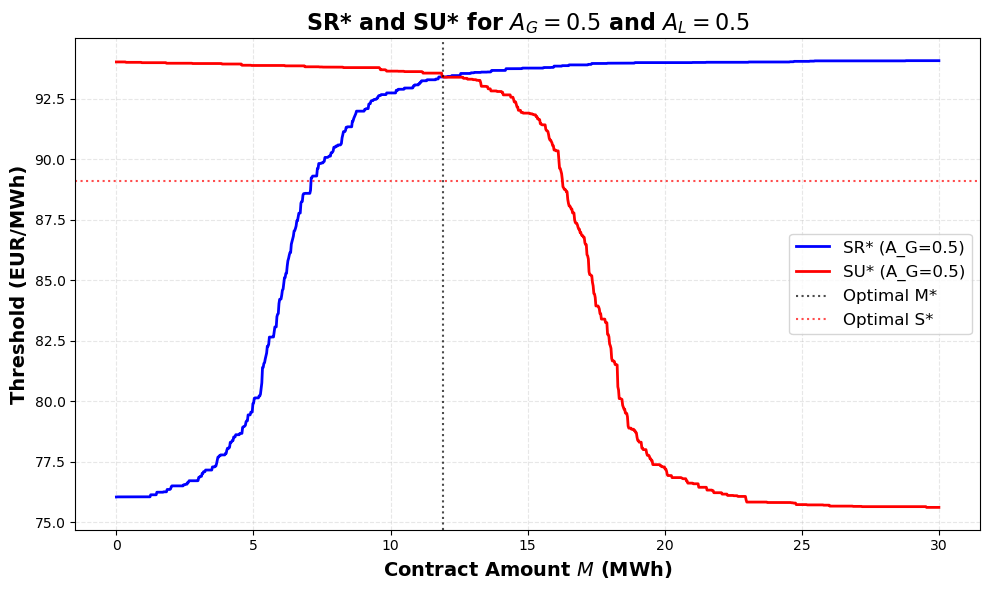

In [221]:
# Find indices for A_G=0.5 and A_L=0.5
A_G_idx = [i for i, val in enumerate(risk_aversion_G) if np.isclose(val, 0.5)][0]
A_L_idx = np.argmin(np.abs(risk_aversion_L - 0.5))



SR_selected = SR_vs_M[A_G_idx, :]
SU_selected = SU_vs_M[A_G_idx, :]
A_L_values_plot = risk_aversion_L

test_SRG = S_G_Star_vs_M_SU[1, closest_idx]
test_SRL = S_G_Star_vs_M_SU[1, closest_idx]

plt.figure(figsize=(10, 6))
plt.plot(M_arr/8760*1e3, S_G_Star_vs_M_SU[1,:], label='SR* (A_G=0.5)', color='blue', linewidth=2)
plt.plot(M_arr/8760*1e3, S_L_Star_vs_M_SU[1,:], label='SU* (A_G=0.5)', color='red', linewidth=2)
plt.xlabel('Contract Amount $M$ (MWh)', fontsize=14, fontweight='bold')
plt.ylabel('Threshold (EUR/MWh)', fontsize=14, fontweight='bold')
plt.title('SR* and SU* for $A_G=0.5$ and $A_L=0.5$', fontsize=16, fontweight='bold')
plt.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal M*')
plt.axhline(model.results.avg_strike_price, color='red', linestyle=':', 
           linewidth=1.5, alpha=0.7, label='Optimal S*')
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [235]:
def compute_SR_star_at_M(
    M: float,
    production: np.ndarray,
    capture_rate: np.ndarray,
    prices: np.ndarray,
    probabilities: np.ndarray,
    A_G: float,
    alpha: float = 0.95,
    discount_factors_G: np.ndarray = None,
    S_min: float = 0.01,  # 10 EUR/MWh
    S_max: float = 0.20   # 200 EUR/MWh
) -> float:
    """
    Find SR*(M) such that du_G/dM = 0 at (M, SR*(M)).
    
    This is the Generator's threshold strike price at contract amount M.
    Below this price, the Generator prefers less contract volume.
    
    From Equation (64) in your PDF:
    du_G/dM = T·S - E(Σλ) - A_G·E(Σλ | π_G(M,S) ≤ VaR_α)
    
    Setting du_G/dM = 0 and solving for S gives SR*(M).
    
    Parameters:
    -----------
    M : float
        Contract amount (GWh/year or MWh)
    production : np.ndarray
        Shape (n_years, n_scenarios) - production levels
    capture_rate : np.ndarray
        Shape (n_years, n_scenarios) - capture rates
    prices : np.ndarray
        Shape (n_years, n_scenarios) - spot prices (EUR/MWh)
    probabilities : np.ndarray
        Shape (n_scenarios,) - scenario probabilities
    A_G : float
        Generator's risk aversion [0, 1]
    alpha : float
        CVaR confidence level (default 0.95)
    discount_factors_G : np.ndarray, optional
        Shape (n_years, 1) - discount factors
    S_min : float
        Minimum strike price for search (EUR/MWh as decimal, e.g., 0.01 = 10 EUR/MWh)
    S_max : float
        Maximum strike price for search (EUR/MWh as decimal, e.g., 0.20 = 200 EUR/MWh)
    
    Returns:
    --------
    float
        SR*(M) in EUR/MWh (e.g., 85.5 means 85.5 EUR/MWh)
    """
    from scipy.optimize import brentq
    
    # Normalize probabilities
    #probabilities = probabilities / probabilities.sum()
    
    # Apply discounting
    if discount_factors_G is not None:
        discounted_prices = prices * discount_factors_G
        lambda_sum = discounted_prices.sum(axis=0)  # Sum over years → (n_scenarios,)
        T_effective = discount_factors_G.sum()
    else:
        lambda_sum = prices.sum(axis=0)
        T_effective = prices.shape[0]
    
    # Expected lambda (doesn't depend on M or S)
    expected_lambda = (probabilities * lambda_sum).sum()
    
    # Spot revenue without contract (doesn't depend on S)
    total_production_CR = production * capture_rate
    if discount_factors_G is not None:
        spot_revenue_base = (total_production_CR * prices * discount_factors_G).sum(axis=0)
    else:
        spot_revenue_base = (total_production_CR * prices).sum(axis=0)
    
    def objective(S):
        """
        Compute du_G/dM at (M, S).
        SR*(M) is where this equals zero.
        """
        # Contract payoff at (M, S)
        if discount_factors_G is not None:
            contract_payoff = ((S - prices) * M * discount_factors_G).sum(axis=0)
        else:
            contract_payoff = ((S - prices) * M).sum(axis=0)
        
        # Total earnings at (M, S)
        earnings_G = spot_revenue_base + contract_payoff
        
        # Find left tail (worst scenarios for Generator)
        ord_G, bidx_G = _left_tail_mask(earnings_G, probabilities, alpha)
        
        # Conditional expectation in tail
        tail_lambda_G = _left_tail_weighted_sum(
            probabilities, lambda_sum, ord_G, bidx_G, alpha
        )
        
        # From Equation (64): du_G/dM = T·S - [E(Σλ) + A_G·E(Σλ|tail)]
        du_dM = T_effective * S - ((1 - A_G) * expected_lambda + A_G * tail_lambda_G)
        
        return du_dM
    
    # Check if objective has a root in the interval
    obj_min = objective(S_min)
    obj_max = objective(S_max)
    
    if obj_min * obj_max > 0:
        # No sign change - root not in interval
        if abs(obj_min) < abs(obj_max):
            print(f"Warning: SR*(M={M:.2f}) not found in [{S_min*1e3:.1f}, {S_max*1e3:.1f}] EUR/MWh")
            print(f"  Returning lower bound. Consider expanding search range.")
            return S_min * 1e3
        else:
            print(f"Warning: SR*(M={M:.2f}) not found in [{S_min*1e3:.1f}, {S_max*1e3:.1f}] EUR/MWh")
            print(f"  Returning upper bound. Consider expanding search range.")
            return S_max * 1e3
    
    try:
        # Find root using Brent's method
        S_star = brentq(objective, S_min, S_max, xtol=1e-8, maxiter=1000)
        return S_star * 1e3  # Convert to EUR/MWh
    except ValueError as e:
        print(f"Error finding SR*(M={M:.2f}): {e}")
        return expected_lambda / T_effective * 1e3  # Fallback to expected price


def compute_SU_star_at_M(
    M: float,
    consumption: np.ndarray,
    load_CR: np.ndarray,
    prices: np.ndarray,
    probabilities: np.ndarray,
    A_L: float,
    alpha: float = 0.95,
    discount_factors_L: np.ndarray = None,
    S_min: float = 0.01,  # 10 EUR/MWh
    S_max: float = 0.20   # 200 EUR/MWh
) -> float:
    """
    Find SU*(M) such that du_L/dM = 0 at (M, SU*(M)).
    
    This is the Load's threshold strike price at contract amount M.
    Above this price, the Load prefers less contract volume.
    
    From Equation (68) in your PDF:
    du_L/dM = -T·S + E(Σλ) + A_L·E(Σλ | π_L(M,S) ≤ VaR_α)
    
    Setting du_L/dM = 0 and solving for S gives SU*(M).
    
    Parameters:
    -----------
    M : float
        Contract amount (GWh/year or MWh)
    consumption : np.ndarray
        Shape (n_years, n_scenarios) - load consumption levels
    load_CR : np.ndarray
        Shape (n_years, n_scenarios) - load capture rates
    prices : np.ndarray
        Shape (n_years, n_scenarios) - spot prices (EUR/MWh)
    probabilities : np.ndarray
        Shape (n_scenarios,) - scenario probabilities
    A_L : float
        Load's risk aversion [0, 1]
    alpha : float
        CVaR confidence level (default 0.95)
    discount_factors_L : np.ndarray, optional
        Shape (n_years, 1) - discount factors
    S_min : float
        Minimum strike price for search (EUR/MWh as decimal)
    S_max : float
        Maximum strike price for search (EUR/MWh as decimal)
    
    Returns:
    --------
    float
        SU*(M) in EUR/MWh
    """
    from scipy.optimize import brentq
    
    # Normalize probabilities
    #probabilities = probabilities / probabilities.sum()
    
    # Apply discounting
    if discount_factors_L is not None:
        discounted_prices = prices * discount_factors_L
        lambda_sum = discounted_prices.sum(axis=0)  # Sum over years → (n_scenarios,)
        T_effective = discount_factors_L.sum()
    else:
        lambda_sum = prices.sum(axis=0)
        T_effective = prices.shape[0]
    
    # Expected lambda (doesn't depend on M or S)
    expected_lambda = (probabilities * lambda_sum).sum()
    
    # Spot cost without contract (doesn't depend on S)
    total_consumption_LR = consumption * load_CR
    if discount_factors_L is not None:
        spot_cost_base = -(total_consumption_LR * prices * discount_factors_L).sum(axis=0)
    else:
        spot_cost_base = -(total_consumption_LR * prices).sum(axis=0)
    
    def objective(S):
        """
        Compute du_L/dM at (M, S).
        SU*(M) is where this equals zero.
        """
        # Contract payoff at (M, S)
        if discount_factors_L is not None:
            contract_payoff = ((prices - S) * M * discount_factors_L).sum(axis=0)
        else:
            contract_payoff = ((prices - S) * M).sum(axis=0)
        
        # Total earnings (negative cost) at (M, S)
        earnings_L = spot_cost_base + contract_payoff
        
        # Find left tail (worst scenarios for Load = high price scenarios)
        ord_L, bidx_L = _left_tail_mask(earnings_L, probabilities, alpha)
        
        # Conditional expectation in tail
        tail_lambda_L = _left_tail_weighted_sum(
            probabilities, lambda_sum, ord_L, bidx_L, alpha
        )
        
        # From Equation (68): du_L/dM = E(Σλ) - T·S + A_L·E(Σλ|tail)
        du_dM = -T_effective * S + ((1 - A_L) * expected_lambda + A_L * tail_lambda_L)
        
        return du_dM
    
    # Check if objective has a root in the interval
    obj_min = objective(S_min)
    obj_max = objective(S_max)
    
    if obj_min * obj_max > 0:
        # No sign change - root not in interval
        if abs(obj_min) < abs(obj_max):
            print(f"Warning: SU*(M={M:.2f}) not found in [{S_min*1e3:.1f}, {S_max*1e3:.1f}] EUR/MWh")
            print(f"  Returning lower bound. Consider expanding search range.")
            return S_min * 1e3
        else:
            print(f"Warning: SU*(M={M:.2f}) not found in [{S_min*1e3:.1f}, {S_max*1e3:.1f}] EUR/MWh")
            print(f"  Returning upper bound. Consider expanding search range.")
            return S_max * 1e3
    
    try:
        # Find root using Brent's method
        S_star = brentq(objective, S_min, S_max, xtol=1e-8, maxiter=1000)
        return S_star * 1e3  # Convert to EUR/MWh
    except ValueError as e:
        print(f"Error finding SU*(M={M:.2f}): {e}")
        return expected_lambda / T_effective * 1e3  # Fallback to expected price

Computing SR*(M) and SU*(M)...
  Progress: 0/200
  Progress: 20/200
  Progress: 40/200
  Progress: 60/200
  Progress: 80/200
  Progress: 100/200
  Progress: 120/200
  Progress: 140/200
  Progress: 160/200
  Progress: 180/200
✓ Complete


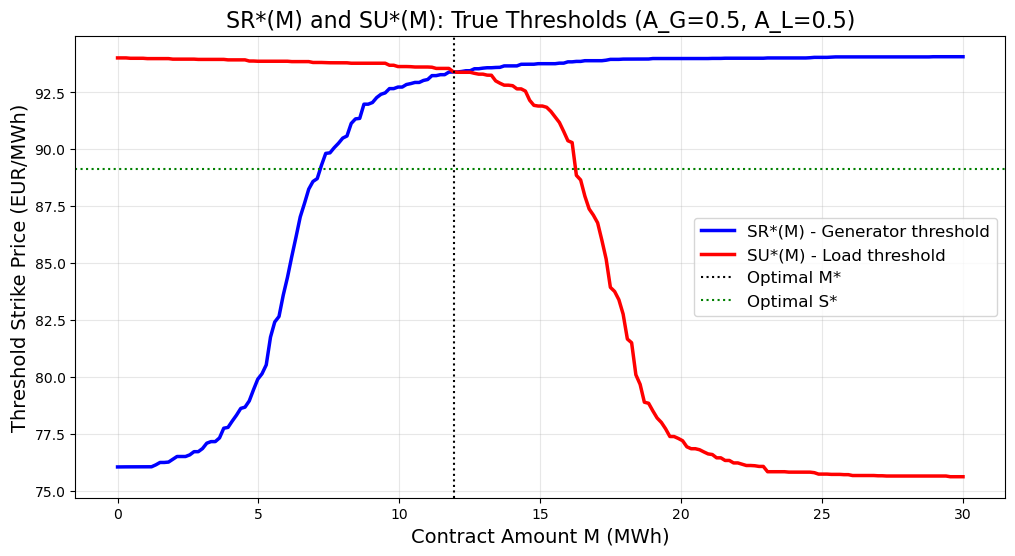


INDIVIDUAL RATIONALITY CHECK AT OPTIMAL (M*, S*)
Optimal contract:
  M* = 0.0000 GWh/year = 11.92 MWh
  S* = 89.12 EUR/MWh

Thresholds at M*:
  SR*(M*) = 76.05 EUR/MWh (Generator's minimum)
  SU*(M*) = 94.02 EUR/MWh (Load's maximum)

Feasibility:
  ✓ FEASIBLE: 76.05 ≤ 89.12 ≤ 94.02
  → Both parties are better off than no contract


In [238]:
# Example: Compute thresholds at different M values
M_arr = np.linspace(0, 30 * 8760 * 1e-3, 200)  # GWh/year

SR_vs_M = []
SU_vs_M = []

print("Computing SR*(M) and SU*(M)...")
for i, M_value in enumerate(M_arr):
    if i % 20 == 0:
        print(f"  Progress: {i}/{len(M_arr)}")
    
    # Generator threshold
    SR = compute_SR_star_at_M(
        M=M_value,
        production=prod,
        capture_rate=CR,
        prices=prices,
        probabilities=PROB,
        A_G=A_G,
        alpha=alpha,
        discount_factors_G=discount_factors_G,
        S_min=0.03,  # 30 EUR/MWh
        S_max=0.15   # 150 EUR/MWh
    )
    SR_vs_M.append(SR)
    
    # Load threshold
    SU = compute_SU_star_at_M(
        M=M_value,
        consumption=load,
        load_CR=LR,
        prices=prices,
        probabilities=PROB,
        A_L=A_L,
        alpha=alpha,
        discount_factors_L=discount_factors_L,
        S_min=0.03,
        S_max=0.15
    )
    SU_vs_M.append(SU)

print("✓ Complete")

# Convert to arrays
SR_vs_M = np.array(SR_vs_M)
SU_vs_M = np.array(SU_vs_M)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(M_arr / 8760 * 1e3, SR_vs_M, label='SR*(M) - Generator threshold', linewidth=2.5, color='blue')
plt.plot(M_arr / 8760 * 1e3, SU_vs_M, label='SU*(M) - Load threshold', linewidth=2.5, color='red')
plt.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
            linewidth=1.5, label='Optimal M*')
plt.axhline(model.results.avg_strike_price, color='green', linestyle=':', 
            linewidth=1.5, label='Optimal S*')
plt.xlabel('Contract Amount M (MWh)', fontsize=14)
plt.ylabel('Threshold Strike Price (EUR/MWh)', fontsize=14)
plt.title(f'SR*(M) and SU*(M): True Thresholds (A_G={A_G}, A_L={A_L})', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Check feasibility at optimal point
M_optimal = model.results.avg_contract_amount_hour / 8760 * 1e-3  # GWh/year
S_optimal = model.results.avg_strike_price  # EUR/MWh

SR_at_optimal = compute_SR_star_at_M(
    M=M_optimal, production=prod, capture_rate=CR, prices=prices,
    probabilities=PROB, A_G=A_G, alpha=alpha, discount_factors_G=discount_factors_G
)

SU_at_optimal = compute_SU_star_at_M(
    M=M_optimal, consumption=load, load_CR=LR, prices=prices,
    probabilities=PROB, A_L=A_L, alpha=alpha, discount_factors_L=discount_factors_L
)

print("\n" + "="*70)
print("INDIVIDUAL RATIONALITY CHECK AT OPTIMAL (M*, S*)")
print("="*70)
print(f"Optimal contract:")
print(f"  M* = {M_optimal:.4f} GWh/year = {M_optimal * 8760 * 1e3:.2f} MWh")
print(f"  S* = {S_optimal:.2f} EUR/MWh")
print(f"\nThresholds at M*:")
print(f"  SR*(M*) = {SR_at_optimal:.2f} EUR/MWh (Generator's minimum)")
print(f"  SU*(M*) = {SU_at_optimal:.2f} EUR/MWh (Load's maximum)")
print(f"\nFeasibility:")
if SR_at_optimal <= S_optimal <= SU_at_optimal:
    print(f"  ✓ FEASIBLE: {SR_at_optimal:.2f} ≤ {S_optimal:.2f} ≤ {SU_at_optimal:.2f}")
    print(f"  → Both parties are better off than no contract")
else:
    print(f"  ✗ INFEASIBLE: {SR_at_optimal:.2f} ≰ {S_optimal:.2f} ≰ {SU_at_optimal:.2f}")
    if S_optimal < SR_at_optimal:
        print(f"  → Generator violation: S* too low by {SR_at_optimal - S_optimal:.2f} EUR/MWh")
    if S_optimal > SU_at_optimal:
        print(f"  → Load violation: S* too high by {S_optimal - SU_at_optimal:.2f} EUR/MWh")
print("="*70)

dCVaR/dM = 1.3629
Initial Threshold at M=0 SR* [EUR/MWh]: 82.907
Initial Threshold at M=0 SU* [EUR/MWh]: 88.379
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 1.47942
Avg Strike Price (EUR/MWh): 86.61244
Lower Strike Price SR* (EUR/MWh): 0.08291
Upper Strike Price SU* (EUR/MWh): 0.08838
Avg Contract Amount (GWh/year): 142.39626
Avg Contract Amount (MWh): 16.25528
Avg Earnings G: 65.74481
Avg Earnings L: -259.73354
CVaR G: 31.47229
CVaR L: -266.82868
Utility G: 62.31756
Utility L: -261.15257
Threat Point G: 57.92715
Threat Point L: -265.54297
Nash Product: 19.27566


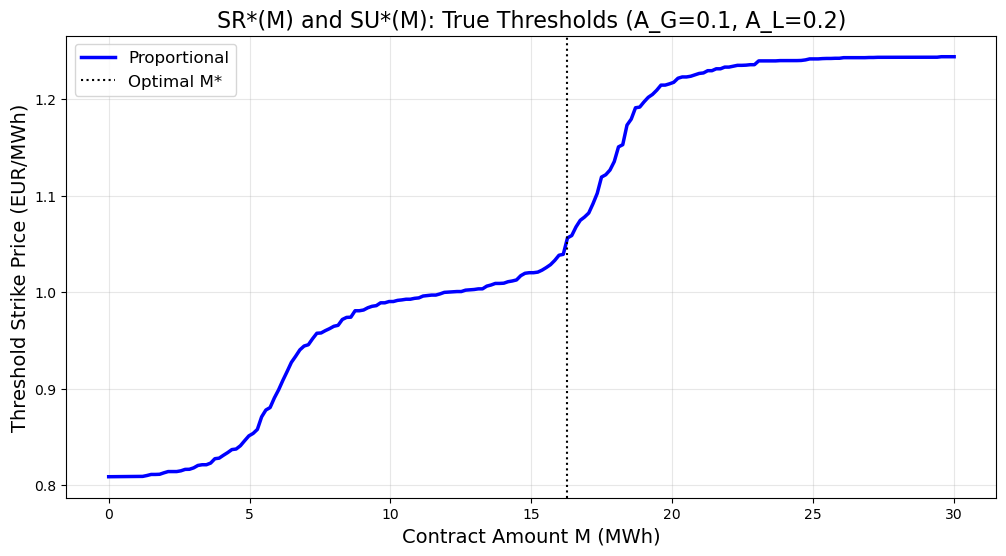

In [249]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.0
discount_rate_L = 0.0
A_G = 0.1
A_L = 0.2
tau_G = 0.5
tau_L = 1-tau_G


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=tau_G,  # Generator's bargaining power
    tau_L=tau_L,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)
# Initialize and run Nash Bargaining model
model = NashBargaining(contract_data)
model.run()


plt.figure(figsize=(12, 6))
plt.plot(M_arr / 8760 * 1e3, SR_vs_M/SU_vs_M, label='Proportional', linewidth=2.5, color='blue')
plt.axvline(model.results.avg_contract_amount_hour, color='black', linestyle=':', 
            linewidth=1.5, label='Optimal M*')
plt.xlabel('Contract Amount M (MWh)', fontsize=14)
plt.ylabel('Threshold Strike Price (EUR/MWh)', fontsize=14)
plt.title(f'SR*(M) and SU*(M): True Thresholds (A_G={A_G}, A_L={A_L})', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()